Cindy Reznikov
SQLAlchemy Homework - connects to and queries an SQL Lite database with 2 tables;  Generates summary stats and 2 graphs.
Bonus challenge - completed 2 of 3 sections

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import datetime as dt

import numpy as np
import pandas as pd
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

#  These are my trip start/end dates for a b-day celebration in Hawaii!

trip_start_date = '2017-08-01'
trip_end_date =  '2017-08-10'

In [3]:
# reflect an existing database into a new model
# reflect the 2 tables

Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()


['measurement', 'station']

In [4]:
# We can view all of the classes that automap found  
# Save references to the measurement table and station tables
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [5]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

print('')
    
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])    

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
# find the latest date in the database - which is: 2017-08-23
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

# Calculate the date 1 year ago from the last data point in the database

one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("One year ago: ", one_year_ago)

One year ago:  2016-08-23


In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results (sort by date)
year_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).\
            order_by(Measurement.date).all()


In [9]:
# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(year_prcp, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)
df = df.dropna(how='all')
df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


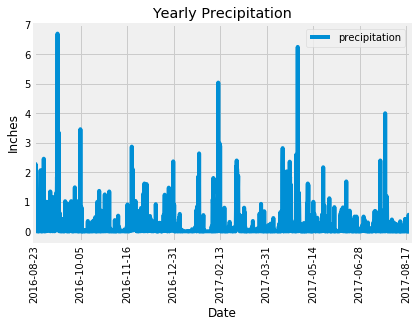

In [10]:
# Use Pandas Plotting with Matplotlib to plot the data in the dataframe (the index (date) becomes the x-axis)

df.plot()

plt.title('Yearly Precipitation')
plt.ylabel('Inches')
plt.xlabel('Date')
plt.xticks(rotation=90)

plt.show()


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [32]:
# Design a query to show how many stations are available in this dataset

station_count = session.query(Measurement).group_by(Measurement.station).count()
station_count
print("Number of stations in the database is: ", station_count)

Number of stations in the database is:  9


In [33]:
# What are the most active stations? (i.e. what stations have the most rows)
# List the stations and the counts in descending order.

sel = [Measurement.station, func.count(Measurement.station)]
active_stations = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()


In [38]:
# capture the most active station

most_active_station = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_active_station
print("The most active station is: ", most_active_station[0])

The most active station is:  USC00519281


In [39]:
all_stations = session.query(Station.station).order_by(Station.station).all()
all_stations

[('USC00511918'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00516128'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519281'),
 ('USC00519397'),
 ('USC00519523')]

In [37]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
sel = [Measurement.station, 
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
min_max_avg = session.query(*sel).filter(Measurement.station == most_active_station[0]).all()

print("The min/max/avg for the most active station is: ", min_max_avg[0])

The min/max/avg for the most active station is:  ('USC00519281', 54.0, 85.0, 71.66378066378067)


In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# find the latest date in the database - 2017-08-23
latest_date2 = session.query(Measurement.date).filter(Measurement.station == most_active_station[0]).\
            order_by(Measurement.date.desc()).first()
latest_date2

('2017-08-18')

In [17]:
# Calculate the date 1 year ago from the last data point in the database

one_year_ago2 = dt.date(2017, 8, 18) - dt.timedelta(days=365)
print("One year ago: ", one_year_ago2)

One year ago:  2016-08-18


In [18]:
# Design a query to retrieve the last 12 months of temp observations
t_obs = session.query(Measurement.tobs).filter(Measurement.date >= one_year_ago2).\
        filter(Measurement.station==most_active_station[0]).all()

#  Load the data from the query into a dataframe
df = pd.DataFrame(t_obs, columns=['tobs'])


Text(0.5, 1.0, 'Yearly Temperature Frequency in Hawaii')

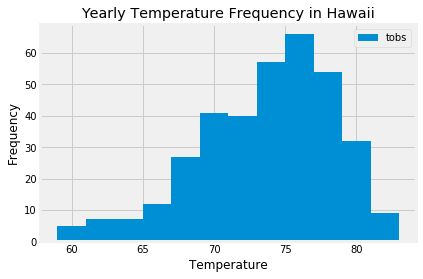

In [19]:
# Create a histogram with 12 bins showing the yearly temperature frequency

df.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Yearly Temperature Frequency in Hawaii")

## Bonus Challenge Assignment

Bonus - Temperature Analysis II - to determine the min,avg, max temp for my vacation timeframe - 1 yr prior - and create a bar chart with an error bar.

In [20]:
# This function will split out the input date, subtract 1 from the year and put it back together as it was

def get_prev_year(input_date):
    try:
        date_list = input_date.split('-')
        last_yr = (str(int(date_list[0])-1)) + '-' + date_list[1] + '-' + date_list[2]
        return last_yr
    except:
        return input_date

In [21]:
# This 2nd function called `calc_temps` will accept start date and end date in the format 'YYYY-MM-DD' 
# and return the minimum, average, and maximum temperatures for that range of dates and put it into a list

def calc_temps(start_date, end_date):
    
    result = session.query(Measurement.tobs).\
        filter(Measurement.date >= start_date, Measurement.date <= end_date).all()

    temp_list = []
    
    temps = [temp[0] for temp in result]
    temp_list.append(min(temps))
    temp_list.append(np.mean(temps))
    temp_list.append(max(temps))
    
    return temp_list

In [22]:
# Call the function 'get_prev_year' (twice) to determine the previous year dates for our planned trip's start/end dates

last_yr_start = get_prev_year(trip_start_date)

last_yr_end = get_prev_year(trip_end_date)

print(last_yr_start, last_yr_end)

2016-08-01 2016-08-10


In [23]:
# Call the function `calc_temps` to calculate the tmin, tavg, and tmax for last year

temp_list = calc_temps(last_yr_start, last_yr_end)

print(temp_list)   


[72.0, 78.33846153846154, 83.0]


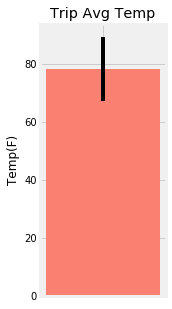

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(2,5))
plt.bar(1,temp_list[1], yerr=(temp_list[2] - temp_list[0]), tick_label='', color='salmon')
plt.title('Trip Avg Temp')
plt.ylabel("Temp(F)")
plt.show()

Bonus:  Temperature Analysis I - t-test comparing June and Dec avg temps

In [28]:
# Calculate the average temp in June

sel = [Measurement.tobs]
june_tobs = session.query(*sel).filter(func.strftime("%m", Measurement.date) == "06").all()


In [29]:
# Calculate the average temp in Dec

sel = [Measurement.tobs]
dec_tobs = session.query(*sel).filter(func.strftime("%m", Measurement.date) == "12").all()


 The independent t-test below tests for the null hypothesis that 2 independent samples have identical average values.  I used an unpaired t-test because I'm comparing temperatures for 2 different months.  Since the p-value (3.90) is greater than 0.05, then we accept the null hypothesis.  There is not a statistically significant difference between the temps in June and Dec.

In [30]:

stats.ttest_ind(june_tobs, dec_tobs)


Ttest_indResult(statistic=array([31.60372399]), pvalue=array([3.9025129e-191]))

Bonus - Daily Rainfall Averages - not completed (yet)

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Station.station, 
       Station.name,
       Station.latitude, 
       Station.longitude, 
       Station.elevation, 
       func.sum(Measurement.prcp)]
station_prcp = session.query(*sel).filter(Measurement.station == Station.station).\
        filter(Measurement.date >= last_yr_start, Measurement.date <= last_yr_end).\
        order_by(func.sum(Measurement.prcp).desc()).\
        group_by(Measurement.station).all()

In [ ]:
# Create a dataframe from the query results

station_prcp_df = pd.DataFrame(station_prcp, columns=['station', 'name', 'lat', 'lng', 'elevation', 'tot precip'])
station_prcp_df.set_index('station', inplace=True)
station_prcp_df

In [ ]:
# This function will split out the input date and return just the month and day

def get_mm_dd(input_date):
    try:
        date_list = input_date.split('-')
        mm_dd = date_list[1] + '-' + date_list[2]
        return mm_dd
    except:
        return input_date

In [ ]:
# This function will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
     
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
#daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`



# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
